In [1]:
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pdb

In [49]:
[224,288,352,416,480,544,608]

[224, 288, 352, 416, 480, 544, 608]

In [51]:
conf.res_map = edict({'ft':0, '224':1, '288':2, '352':3, '416':4, '480':5, '544':6, '608':7})

In [2]:
from easydict import EasyDict as edict
from matplotlib import pyplot as plt
from torchvision import transforms as trans
from PIL import Image
from pathlib import Path
import numpy as np
# np.seterr(all='raise')
import torch
from torch import nn, optim
# import torch.nn.functional as F
from utils.vis_utils import *
from utils.box_utils import *
from utils.dataset_tools import *
from utils.utils import *
from tensorboardX import SummaryWriter
from tqdm import tqdm_notebook as tqdm
from imgaug import augmenters as iaa
from torch.utils.data import DataLoader
from models.Yolo_model import Yolo_model, build_targets, yolo_loss
from Yolo_learner_V2 import Yolo

In [4]:
from collections import namedtuple

In [36]:
conf.resolutions = [224,288,352,416,480,544,608]

In [44]:
steps_tup = namedtuple('steps',['step_{}'.format(resolution) for resolution in conf.resolutions])

In [45]:
steps = steps_tup(0,0,0,0,0,0,0)

In [46]:
steps

steps(step_224=0, step_288=0, step_352=0, step_416=0, step_480=0, step_544=0, step_608=0)

In [41]:
writers = [SummaryWriter('writer_{}'.format(resolution)) for resolution in conf.resolutions]

In [ ]:
for w in writers:
    w.close()

In [ ]:
conf.log_path/

In [42]:
writer = writers[1]

In [43]:
writer.file_writer.get_logdir()

'writer_224'

In [3]:
conf = edict()

conf.coco_anchors = [[10, 13], [16, 30], [33, 23], [30, 61], [62, 45],
                     [59, 119], [116, 90], [156, 198], [373, 326]]
conf.train_path = Path('/home/f/nvme/coco2017/train2017/')
conf.train_anno_path = Path(
    '/home/f/nvme/coco2017/annotations/instances_train2017.json')
conf.val_path = Path('/home/f/nvme/coco2017/val2017/')
conf.val_anno_path = Path(
    '/home/f/nvme/coco2017/annotations/instances_val2017.json')
conf.log_path = Path('/home/f/learning/yolo/log')
conf.model_path = Path('/home/f/learning/yolo/model')
conf.save_path = Path('/home/f/learning/yolo/save')
conf.ids_path = 'data/ids.npy'

conf.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

maps,correct_id_2_class = get_id_maps(conf)

loading annotations into memory...
Done (t=15.84s)
creating index...
index created!


In [4]:
conf.num_anchors = 3
conf.batch_size = 16
conf.input_size = 416
conf.scales = [32,16,8]

conf.running_norm = 0.
# conf.gdclip = 3000.
conf.num_workers = 8
conf.batch_size = 16
conf.gdclip = None
conf.coord_scale = 2.
conf.noobject_scale = 0.5
conf.object_scale = 5
conf.class_scale = 5.
conf.ignore_thresh = 0.5
conf.evaluate_iou_threshold = 0.5
conf.predict_confidence_threshold = 0.5
conf.pred_nms_iou_threshold = 0.5
conf.object_only = True
conf.warm_up_img_num = 12800

model = Yolo_model(conf)
model.to(conf.device)
conf.mean = model.res50_pyramid.model.mean
conf.std = model.res50_pyramid.model.std

conf.mse_loss = nn.MSELoss(size_average=False)
conf.bce_loss = nn.BCEWithLogitsLoss(size_average=False)

# conf.eva_batches = 5
# conf.board_loss_every = 5
# conf.evaluate_every = 5
# conf.board_pred_image_every = 5
# conf.save_every = 5

train_ds = Coco_dataset(conf,conf.train_path,conf.train_anno_path,maps)
train_loader = DataLoader(train_ds,batch_size=conf.batch_size,shuffle=True,collate_fn=coco_collate_fn,pin_memory=True,num_workers=conf.num_workers)
conf.eva_batches = 100
conf.board_loss_every = len(train_loader) // 100
conf.evaluate_every = len(train_loader) // 10
conf.board_pred_image_every = len(train_loader) // 2
conf.save_every = len(train_loader) // 2
conf.board_grad_norm = len(train_loader) // 10
val_dataset = datasets.CocoDetection(conf.val_path, conf.val_anno_path)
val_dataset.maps = maps
conf.transform_test = trans.Compose([
    trans.Resize([conf.input_size,conf.input_size]),
    trans.ToTensor(),
    trans.Normalize(conf.mean, conf.std)
])
val_loader = Coco_loader(
    conf,
    val_dataset,
    conf.transform_test,
    batch_size=conf.batch_size,
    hflip=False,
    shuffle=False)

loading annotations into memory...
Done (t=9.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.32s)
creating index...
index created!


In [5]:
paras = [*model.parameters()][159:]

optimizer = optim.SGD(paras,lr=1e-5,momentum=0.9,weight_decay=1e-4)

In [6]:
writer_ft_head = SummaryWriter(conf.log_path/'ft_head')

In [7]:
yolo = Yolo(conf,model,train_loader,val_loader,writer_ft_head,optimizer)

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:35: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims)
/root/Notebooks/YOLOv3/utils/box_utils.py:102: RuntimeWarning: invalid value encountered in add
  bbox_a[:,2:] += bbox_a[:,:2]
/root/Notebooks/YOLOv3/utils/box_utils.py:107: RuntimeWarning: invalid value encountered in less
  area_i = np.prod(br - tl, axis=2) * (tl < br).all(axis=2)


exited with best_loss at 268.73423151560195


([-8.0,
  -7.993910690121786,
  -7.987821380243572,
  -7.981732070365359,
  -7.975642760487145,
  -7.969553450608931,
  -7.963464140730717,
  -7.957374830852503,
  -7.95128552097429,
  -7.945196211096076,
  -7.939106901217862,
  -7.933017591339648,
  -7.926928281461434,
  -7.920838971583221,
  -7.914749661705007,
  -7.908660351826793,
  -7.902571041948579,
  -7.896481732070365,
  -7.890392422192151,
  -7.884303112313938,
  -7.878213802435724,
  -7.87212449255751,
  -7.866035182679296,
  -7.859945872801082,
  -7.853856562922869,
  -7.847767253044655,
  -7.841677943166441,
  -7.835588633288227,
  -7.829499323410013,
  -7.8234100135318,
  -7.817320703653586,
  -7.811231393775372,
  -7.805142083897158,
  -7.799052774018944,
  -7.792963464140731,
  -7.786874154262517,
  -7.780784844384303,
  -7.774695534506089,
  -7.768606224627875,
  -7.7625169147496615,
  -7.756427604871448,
  -7.750338294993234,
  -7.74424898511502,
  -7.738159675236806,
  -7.732070365358592,
  -7.7259810554803785,
  -7.

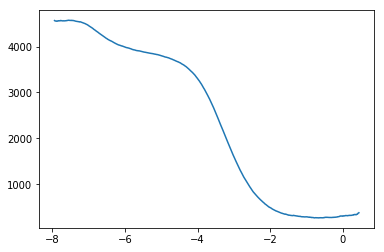

In [8]:
yolo.seen = 2000000
yolo.find_lr(conf)

In [9]:
%debug

In [ ]:
yolo.train(conf,3)

In [ ]:
writer_544 = SummaryWriter(conf.log_path/'size_544')
writer_480 = SummaryWriter(conf.log_path/'size_480')
writer_416 = SummaryWriter(conf.log_path/'size_416')
writer_352 = SummaryWriter(conf.log_path/'size_352')
writer_288 = SummaryWriter(conf.log_path/'size_288')

In [ ]:
yolo.update_size(conf,writer_416)